In [1]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt

Python function to scrape all products from the categories specified from the online fashion retailer Alexander Mcqueen website.

---



In [2]:
# PART 1
def scrapping(s='women',category='ready to wear',language_country='en-gb',subcategory=''):
    website = 'https://www.alexandermcqueen.com'
    
    #ensuring all string are lower case and in the right format
    s = s.lower()
    category = category.lower()
    category = '-'.join(category.split())
    language_country = language_country.lower()
    subcategory = subcategory.lower()
    subcategory = '-'.join(subcategory.split())
    
    #the initial website  url to be opened using beautiful soup
    website= website+'/'+language_country+'/'+s+'/'+category+'/'+subcategory
    
    page = urllib.request.urlopen(website)
    soup = BeautifulSoup(page)
    
    #find the number of products which are on the page specified
    
    num_items = soup.find("span", {"class":"c-filters__count"}).get_text()
    num_items = num_items.strip()
    num_items = num_items.split(' ')
    num_items = int(num_items[0])
    
    # Completely expand the webpage to show all the products, and get the new website url
    load_more_page = soup.find("button", {"class":"c-loadmore__btn"}).get('data-historyurl')
    fullpage = load_more_page.split('&')
    fullpage[-1] = 'sz='+str(num_items)
    fullpage = '&'.join(fullpage)
    fullpage = urllib.request.urlopen(fullpage)
    soup = BeautifulSoup(fullpage)
    
    df = ''


    # iterating through all the products getting the details, and putting them into a dataframe 
    for index in range(1,num_items+1):
        product = soup.find("li", {"class":"l-productgrid__item","data-index":str(index)}).contents[5].get('data-gtmproduct').strip()[1:-1]
        product = product.split(',')
        product = list(product)


        product_details = {}

        for attr in product:

            attr = attr.split(':')
            key = attr[0]
            value = attr[1]

            if key.startswith('"') and key.endswith('"'):
                key = key[1:-1]
            else:
                pass
            if value.startswith('"') and value.endswith('"'):
                 value= value[1:-1]
            else:
                pass
            if value=='null' or value == '':
                value = None
            if len(df) == 0:
                product_details[key] = [value]
            else:
                product_details[key] = value



        if len(df) == 0 :
            df = pd.DataFrame.from_dict(product_details)
        else:
            df = df.append(product_details,ignore_index=True)
    df['price'] = df['price'].apply(pd.to_numeric)

    # dataframe with all the product details to be returned 
    return df

Creating 2 dataframes with products from the women - ready to wear category and the women handbag category.

In [3]:
ready_to_wear_df = scrapping(s='women',category='ready to wear')
handbags_df = scrapping(s='women',category='handbags')

Previewing the ready to wear dataframe

In [4]:
ready_to_wear_df.head()

,id,name,collection,brand,productSMC,material,color,colorId,size,price,discountPrice,coupon,subCategory,category,topCategory,productCategory,stock,list
0,659949Q1AUM9066,ottoman stitch corset wool jumper,S_S_2021,alexander mcqueen,659949Q1AUM9066,None,tea rose,9066,None,1760,None,None,ss21-collection,W-Shop-By,WOMEN,ss21-collection,instock,productList
1,659949Q1AUM9004,ottoman stitch corset wool jumper,S_S_2021,alexander mcqueen,659949Q1AUM9004,None,ivory,9004,None,1760,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,instock,productList
2,659532Q1AUF4100,cropped knit jumper,S_S_2021,alexander mcqueen,659532Q1AUF4100,co,navy,4100,None,570,None,None,ss21-collection-1,W-Collections,WOMEN,ss21-collection-1,instock,productList
3,659532Q1AUF9004,cropped knit jumper,S_S_2021,alexander mcqueen,659532Q1AUF9004,co,ivory,9004,None,570,None,None,ss21-collection-1,W-Collections,WOMEN,ss21-collection-1,outofstock,productList
4,650357Q1ATF1038,embroidered cropped cashmere jumper,S_S_2021,alexander mcqueen,650357Q1ATF1038,None,black/silver,1038,None,650,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,instock,productList


Previewing the handbags dataframe

In [6]:
handbags_df.head()

,id,name,collection,brand,productSMC,material,color,colorId,size,price,discountPrice,coupon,subCategory,category,topCategory,productCategory,stock,list
0,6564671YB451000,the curve,F_W_2021/S_S_2021,alexander mcqueen,6564671YB451000,ve,black,1000,None,1090,None,None,the-curve-1,W-Shop-By,WOMEN,the-curve-1,instock,productList
1,6564671YB419090,the curve,F_W_2021/S_S_2021,alexander mcqueen,6564671YB419090,ve,ivory,9090,None,1090,None,None,the-curve-1,W-Shop-By,WOMEN,the-curve-1,outofstock,productList
2,6564671YB409900,the curve,F_W_2021/S_S_2021,alexander mcqueen,6564671YB409900,ve,pink,9900,None,1090,None,None,the-curve-1,W-Shop-By,WOMEN,the-curve-1,instock,productList
3,6564671YB402002,the curve,F_W_2021/S_S_2021,alexander mcqueen,6564671YB402002,ve,tan,2002,None,1090,None,None,the-curve-1,W-Shop-By,WOMEN,the-curve-1,instock,productList
4,6564671YB423501,the curve,F_W_2021/S_S_2021,alexander mcqueen,6564671YB423501,ve,lime green,3501,None,1090,None,None,the-curve-1,W-Shop-By,WOMEN,the-curve-1,instock,productList


# **Analysis of the dataframes**

A distribution of the number of products across the different collections.

The Spring/Summer 2021 collection, currently has the most products. Not unusual as this is latest collection, so there will be a shift in the products being sold due to the new season.

The Fall/Winter Season collection comes in 2nd place, as this was the previous being offered, so there are still quite a few products left.

The collections are products which have spanned multiple season or have been available for a few years. There are small amounts of products in these categories. This distribution shows there is a focus on offering products from the Spring/Summer 2021 collection.

In [7]:
ready_to_wear_df['collection'].value_counts()

S_S_2021                                                                 160
F_W_2020                                                                  46
F_W_2021/S_S_2021                                                          7
20193/F_W_2019/F_W_2020/F_W_2021/STAG_X_STILL_VALID/S_S_2020/S_S_2021      6
F_W_2020/S_S_2021                                                          6
S_S_2020                                                                   2
F_W_2017/STAG_X_STILL_VALID/S_S_2018                                       1
20191/F_W_2018/STAG_X_STILL_VALID/S_S_2019                                 1
20183/F_W_2018/STAG_X_STILL_VALID/S_S_2019                                 1
STAG_X_STILL_VALID/S_S_2020                                                1
20193/F_W_2019/STAG_X_STILL_VALID                                          1
F_W_2020/STAG_X_STILL_VALID/S_S_2021                                       1
20191/F_W_2018/STAG_X_STILL_VALID/S_S_2018/S_S_2019                        1

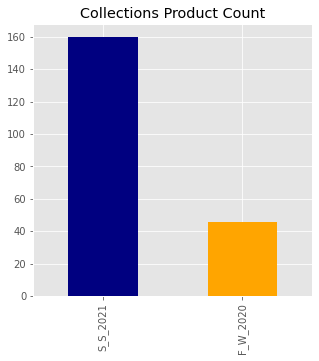

In [8]:
plt.style.use('ggplot') 
ready_to_wear_df['collection'].loc[(ready_to_wear_df['collection']=='S_S_2021') | (ready_to_wear_df['collection']=='F_W_2020')].value_counts().plot(kind='bar',figsize=(5,5),title='Collections Product Count',color=['navy','orange'])


Upon inspection, majority of the prodcuts in the Ready-To-Wear section are in in stock, and there is small amount of products which are available for preorder and which are out of stock.

The out of stock items would be a point of interest, to gauge the populairity of a product in terms of how quickly it took to be out of stock or look into whether it was a new season product or last season.  

instock       196
outofstock     42
Name: stock, dtype: int64


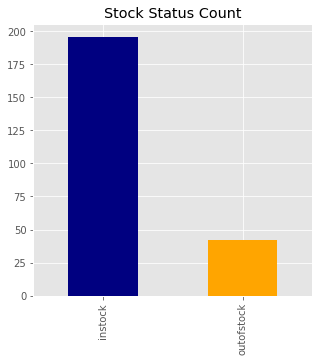

In [9]:
print(ready_to_wear_df['stock'].value_counts())
ready_to_wear_df['stock'].value_counts().plot(kind='bar',figsize=(5,5),title='Stock Status Count',color=['navy','orange','red'])

The items which are out of stock would worth looking into the reasons why, for example was it very limited, so it sold out quick or was there a reasonable amount of stock but the product had high popularity therefore went out of stock.

Comparing the price of out of stock items to the average price in that category will give us insight as whether price has played a part or not in influencing the sells of a product 

In [10]:
print(ready_to_wear_df[['productCategory','stock']].value_counts())

productCategory          stock     
w-view-all-2             instock       74
ss21-collection-1        instock       44
w-ss21-pre-collection    instock       28
w-view-all-2             outofstock    20
w-tailoring              instock       18
w-ss21-pre-collection-1  instock       16
ss21-collection-1        outofstock    13
w-knitwear               instock        5
w-dresses                instock        5
w-tailoring              outofstock     3
w-skirts                 outofstock     2
                         instock        2
w-ss21-pre-collection-1  outofstock     2
w-outerwear              instock        1
w-leather                outofstock     1
w-dresses                outofstock     1
w-t-shirts-sweatshirts   instock        1
w-tops-and-shirts        instock        1
ss21-collection          instock        1
dtype: int64



Added new column to check whether the price for the outstock item is above or below average for the product category it is from.

In [11]:
outofstock = ready_to_wear_df[ready_to_wear_df['stock'] == 'outofstock'].sort_values(by=['price'],ascending=False)

outofstock['above or below avg'] = outofstock.apply(lambda x: 'above' if x['price'] > ready_to_wear_df.loc[ready_to_wear_df['productCategory'] == x['productCategory'],['price']].mean().values else 'below',axis=1 )

outofstock

,id,name,collection,brand,productSMC,material,color,colorId,size,price,discountPrice,coupon,subCategory,category,topCategory,productCategory,stock,list,above or below avg
75,660191QZAC00615,bustier tulle dress,S_S_2021,alexander mcqueen,660191QZAC00615,None,rose pink,0615,None,10000,None,None,ss21-collection-1,W-Collections,WOMEN,ss21-collection-1,outofstock,productList,above
202,507772Q5KWI1000,leather biker jacket,20183/F_W_2018/STAG_X_STILL_VALID/S_S_2019,alexander mcqueen,507772Q5KWI1000,oz/se,black,1000,None,3745,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,outofstock,productList,above
198,659732Q5AFZ1000,leather buckle jacket,S_S_2021,alexander mcqueen,659732Q5AFZ1000,oz/vt/se,black,1000,None,3490,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,outofstock,productList,above
215,659801Q5AF41091,hybrid leather biker jacket,S_S_2021,alexander mcqueen,659801Q5AF41091,bu/co/vt/co/se,black/blue,1091,None,3450,None,None,ss21-collection-1,W-Collections,WOMEN,ss21-collection-1,outofstock,productList,above
211,649544QKAAL9710,double breasted camel coat,S_S_2021,alexander mcqueen,649544QKAAL9710,wk,camel,9710,None,2990,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,outofstock,productList,above
197,659837Q5AF71000,tulle biker jacket,S_S_2021,alexander mcqueen,659837Q5AF71000,bu/se/pa/vt/bu/se,black,1000,None,2780,None,None,ss21-collection-1,W-Collections,WOMEN,ss21-collection-1,outofstock,productList,above
116,636264QJAAA1000,prince of wales spliced jacket,F_W_2020,alexander mcqueen,636264QJAAA1000,wo/se/pa,black,1000,None,2670,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,outofstock,productList,above
176,659798Q5AGE1000,leather wrap skirt,S_S_2021,alexander mcqueen,659798Q5AGE1000,None,black,1000,None,2640,None,None,W-Leather,W-All-Ready-to-Wear,WOMEN,w-leather,outofstock,productList,below
101,657961QJACD1080,trompe l'œil prince of wales jacket,S_S_2021,alexander mcqueen,657961QJACD1080,wv,black/ivory,1080,None,2550,None,None,W-Tailoring,W-All-Ready-to-Wear,WOMEN,w-tailoring,outofstock,productList,above
107,631835QBAAW6035,double-breasted duchesse jacket,F_W_2020,alexander mcqueen,631835QBAAW6035,se/ac/se,carnelian red,6035,None,2490,None,None,w-view-all-2,W-All-Ready-to-Wear,WOMEN,w-view-all-2,outofstock,productList,above


Distribution of out of stock products which are priced below or above the average price for their respective categories.

below    25
above    17
Name: above or below avg, dtype: int64


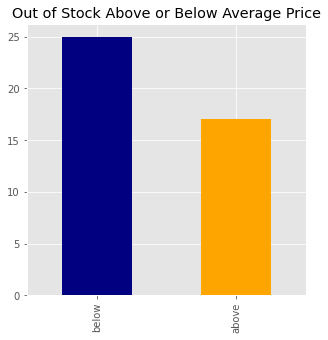

In [12]:
print(outofstock['above or below avg'].value_counts())
outofstock['above or below avg'].value_counts().plot(kind='bar',figsize=(5,5),title='Out of Stock Above or Below Average Price',color=['navy','orange'])